In [77]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [78]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [79]:
data = pd.read_csv('IT_sector.csv')
print(data.head())
print(data.info())
print(data.describe())

         Date      Open      High   ...    Close   Shares Traded   Turnover (Cr)
0  01-DEC-2017  11123.60  11180.40  ...  10948.50      15744634.0         766.04
1  04-DEC-2017  11007.95  11138.10  ...  11081.65      28758345.0        1619.53
2  05-DEC-2017  11079.35  11121.85  ...  11025.40      22390897.0        1209.54
3  06-DEC-2017  11024.55  11099.05  ...  11074.90      26426388.0        1170.90
4  07-DEC-2017  11075.55  11178.80  ...  11163.45      25529596.0        1338.80

[5 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1900 non-null   object 
 1   Open            1900 non-null   float64
 2   High            1900 non-null   float64
 3   Low             1900 non-null   float64
 4   Close           1900 non-null   float64
 5   Shares Traded   1898 non-null   float64
 6   Turnover (Cr)   1898 

In [80]:
data.columns = data.columns.str.strip()  # Remove spaces from column names
print(data.isna().sum())
# Remove spaces from string data in the entire DataFrame
df = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.fillna(0, inplace=True)  # Fill NaN values with 0

Date             0
Open             0
High             0
Low              0
Close            0
Shares Traded    2
Turnover (Cr)    2
dtype: int64


/tmp/ipython-input-2658510332.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [81]:
data['returns'] = data['Close'].pct_change()
data['returns']=data['returns']*100
data['volatility'] = data['returns'].rolling(window=15).std()   #To get the annualized volatility
data['volatility'].fillna(0, inplace=True)

/tmp/ipython-input-3817787588.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['volatility'].fillna(0, inplace=True)


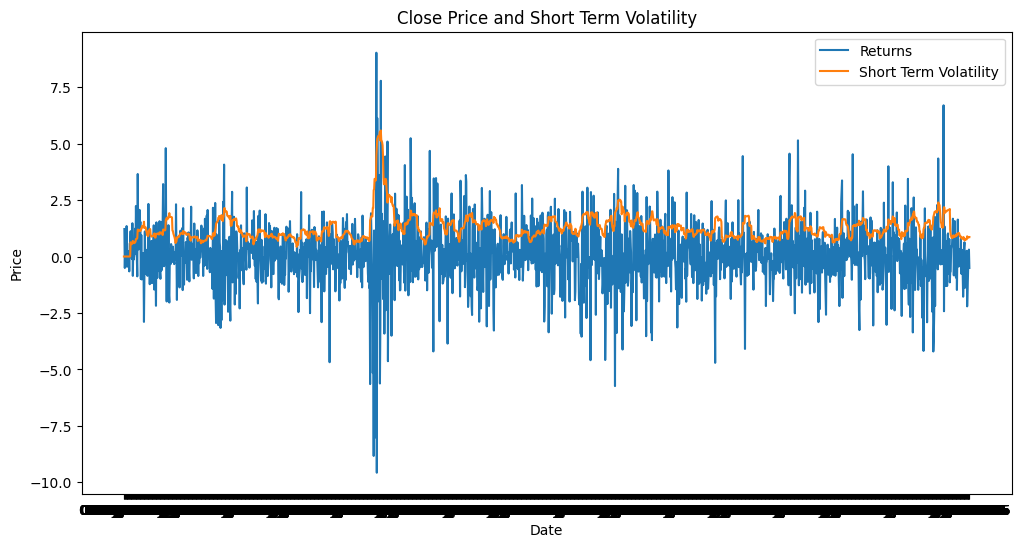

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['returns'], label='Returns')
plt.plot(data['Date'], data['volatility'], label='Short Term Volatility')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price and Short Term Volatility')
plt.legend()
plt.show()

In [83]:
numeric_data = data.select_dtypes(include=["int64", "float64"]) #Only selcting the data which is numeric

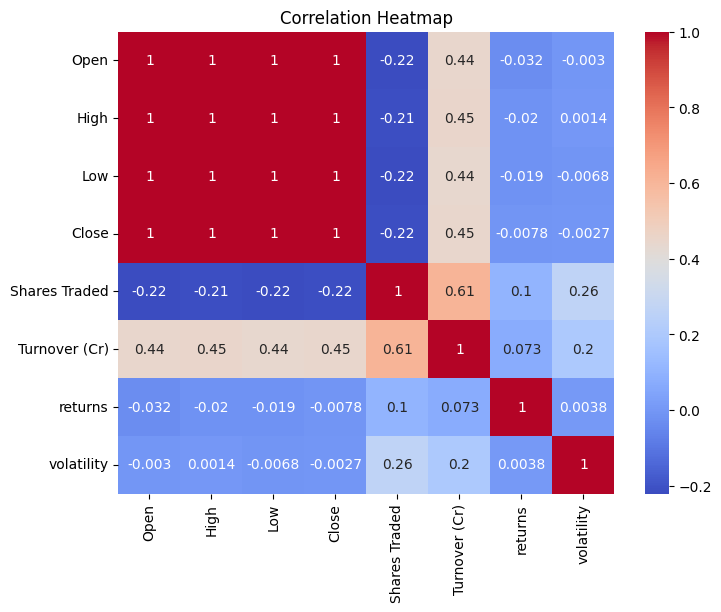

In [84]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [85]:
#convert the data into date time then create a date filter
data['Date'] = pd.to_datetime(data['Date'])
prediction = data.loc[(data['Date'] > datetime(2018,1,1)) & (data['Date'] < datetime(2024,1,1))]

/tmp/ipython-input-4099536068.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


<h2> Prepare the Sequencial Model </h2>

In [86]:
market_volatility = data['volatility'].values.reshape(-1,1) #convert to numpy array
train_len = int(np.ceil(len(market_volatility))*0.9) # 90 % of total data for training

In [87]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(market_volatility)
training_data = scaler.fit_transform(market_volatility[:train_len].reshape(-1,1))

In [88]:
X_train, y_train = [],[]

window = 30
#Sliding windwo for the volatility a month
for i in range(window, len(training_data)):
    X_train.append(training_data[i-window:i,0])
    y_train.append(training_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  #Neural networks, especially LSTMs, expect input data in this 3D format: (samples, time_steps, features)




In [89]:
#Build the model
model = keras.models.Sequential()

#First layer
model.add(keras.layers.LSTM(512, return_sequences=True, activation="relu", input_shape=(X_train.shape[1],1)))

#Second layer
model.add(keras.layers.LSTM(512,activation="relu", return_sequences=True))

#Third layer (Dropout)
model.add(keras.layers.Dropout(0.5))

#fourth layer (LSTM) - Changed from Dense
model.add(keras.layers.LSTM(256, activation="relu", return_sequences=True))

#fifth layer (Dropout)
model.add(keras.layers.Dropout(0.5))

#Sixth layer (LSTM)
model.add(keras.layers.LSTM(128,activation="relu",return_sequences=False)) #The last of the lstm layer should have the return_sequence = False

#Seventh layer (Dropout)
model.add(keras.layers.Dropout(0.2)) # Reduced dropout

#Eighth layer (Dense)
model.add(keras.layers.Dense(1))


model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

# training the model
training  = model.fit(X_train, y_train, batch_size=32, epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 30, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 30, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 30, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,136,577 (15.78 MB)

 Trainable params: 4,136,577 (15.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.6804 - root_mean_squared_error: 1.8109
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.4826 - root_mean_squared_error: 0.8301
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 0.3440 - root_mean_squared_error: 0.5559
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.3029 - root_mean_squared_error: 0.4754
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 0.2799 - root_mean_squared_error: 0.4466
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.2544 - root_mean_squared_error: 0.3980
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.2634 - root_mean_squared_error: 0.4061
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.2318 - root_mean_squared_error: 0.3880
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.2297 - root_mean_squared_error: 0.3922
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.2162 - root_mean_squared_error: 0.3898
Epoch 11/

In [90]:
#Preparing for the test data
test_data = scaled_data[train_len-60:]
X_test, y_test = [],[]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step


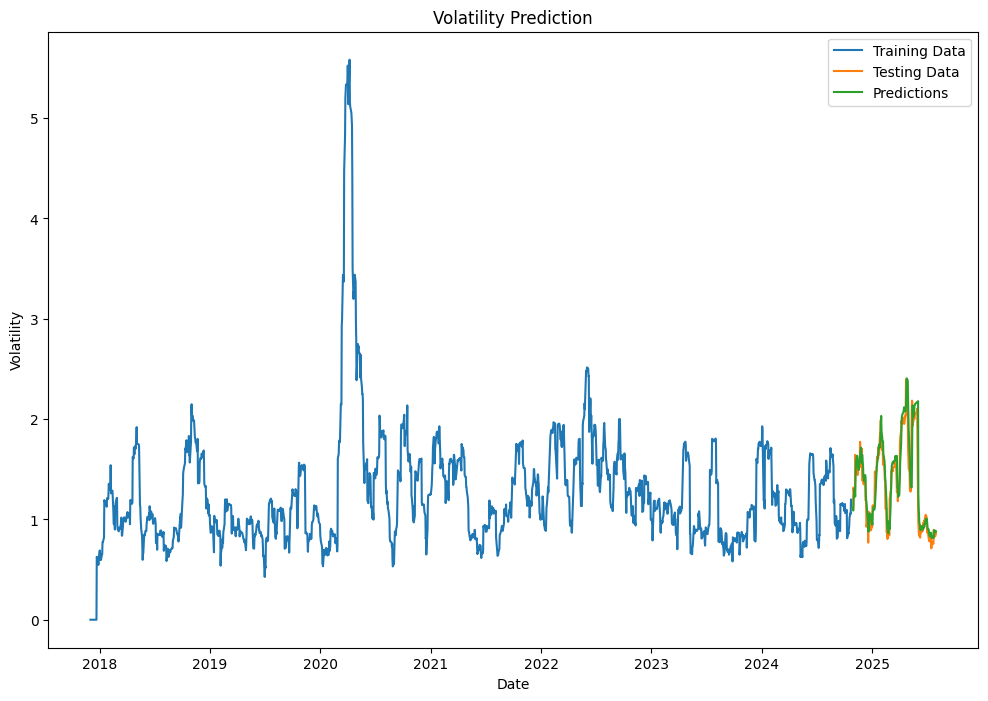

In [91]:
# make prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

#plotting data
train = data[:train_len]
test = data[train_len:]

test = test.copy()
test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['Date'], train['volatility'], label='Training Data')
plt.plot(test['Date'], test['volatility'], label='Testing Data')
plt.plot(test['Date'], test['Predictions'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Prediction')
plt.legend()
plt.show()


In [92]:
# Evaluate the model

test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - loss: 0.1865 - root_mean_squared_error: 0.2619
Test Loss: 0.1952
Test RMSE: 0.2918


In [93]:
#save the model
model.save('volatility_prediction_model.h5')